<a href="https://colab.research.google.com/github/asouzujoseph/Machine-learning-with-Python/blob/main/Assignment_4_Multi_label_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SCS 3253: Machine Learning
> Assignment 4: Multi-label Text Classification

> Assigned: July 19th, 2022

> **Due Date: August 2nd, 2022, 6:30pm EST**

Please review the assignment early so you have ample opportunity to ask clarifying questions. 

### Your name & student number:

<pre> Name: Nnamdi joseph Asouzu </pre>

<pre> Student Number: X487118 </pre>


# Instructions and Marking Guidelines
***
This assignment will account for 15% of your final grade. It is worth 30 marks in total **(8 for Part 1, 6 for Part 2, and 16 for Part 3).**

Please read the provided markdown (text) cells carefully. Some subsections contain multiple questions. Be sure to answer all questions. 

Answers should be provided within this same notebook and will be a mix of code, outputs (e.g. plots, trained models), and written reponses. 

#### TIPS


> ⏳ **Please budget 4-5 hours to complete each assignment.** Reach out to us if you think your assignment will be more than 1 week late. 

> 📚 **You will likely need to refer to the documentation of libraries such as sklearn** while completing this assignment. Looking up things in 'the docs' is part of the day-to-day life of a Data Scientist. We encourage you to visit the docs if you haven't already. It's a great way to become more familiar and comfortable with the ML tools available to you. **When in doubt, GOOGLE!** 
* You can find the scikit-learn docs [here](https://scikit-learn.org/stable/modules/classes.html)
* You can also find a variety of helpful guides and tutorials through the [main scikit-learn website](https://scikit-learn.org/stable/)
* Other helpful references can be found here:
 * [MatPlotLib](https://matplotlib.org/)
 * [Seaborn](seaborn.pydata.org)
 * [Pandas](https://pandas.pydata.org/docs/)
 * [Numpy](https://numpy.org/doc/)


> 💣  **When you enounter errors** (because it's a law of nature in coding), please carefully read what the error message is telling you. Debugging is a key skill to develop. It's about understanding the root cause of an error, trying a fix, and repeating with a new hypothesis as necessary. If you get totally stuck, try googling the error message. You can find many common errors and solutions documented on [stackoverflow](https://stackoverflow.com/). 



### Marking Guidelines

All questions will state the number of marks available, e.g. [X points].

In machine learning, there is not necessarily one "correct" answer to a given modelling problem. You **do not** need to have the "best" performing model in the class in order to receive full marks. Rather, we will be marking assignments individually, based on the following criteria:

* **Demonstration of core concepts [40%]**
 * Do your answers to written questions demonstrate you understand and can apply the core concepts taught in class? Are those answers justified by the calculations / plots / models you produced?

* **Reasonable outputs [30%]** 
 * Do the values you obtain make sense? Did you follow the expected steps. Do you show all steps and make your reasoning clear?

* **Effort [15%]** 
 * Are data visualizations or plots clear and easy to interpret? Did you make a reasonable effort to maximize the performance of the models you submitted?

* **Clean code [15%]** 
 * Is your python code easy to follow? Related code should be organized into re-usable functions and not be scattered across notebook cells. Function and variable names should be well-chosen to convey what they do or represent. Functions should have docstrings explaining what they do. Comments should be used to explain the details of what you are doing, to help your evaluator follow along. 

In [ ]:
# === NOTEBOOK & IMPORT SETUP ===
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
from ast import literal_eval
import tensorflow as tf
import nltk
import re
import string

pd.set_option("display.max_columns", None)
%matplotlib inline

# Dataset: Research Paper Topic Prediction
***
In this assignment, you will build a multi-label text classifier to predict the subject areas of arXiv (https://arxiv.org/) papers from their titles and abstract bodies. This type of classifier can be useful for conference submission portals like OpenReview. Given a paper abstract, the portal could provide suggestions for which areas the paper would best belong to.

The raw dataset contains 51,774 rows and 3 columns. The columns include:
- `titles`: The title of the research paper.
- `summaries`: The research paper abstract.
- `terms`: The subject area(s) (there can be multiple) for the research paper. These are your labels. Example labels include Machine Learning (cs.LG), Artificial Intelligence (cs.AI), and Cryptography and Security (cs.CR).

We perform some light data cleaning below to remove duplicates and process the labels. **The final dataset you will be working with will be stored in the pandas dataframe `df_clean`.**


## Load Data

In [ ]:
# Load data directly from github
df = pd.read_csv("https://github.com/soumik12345/multi-label-text-classification/releases/download/v0.2/arxiv_data.csv")
print(f"Raw data shape: {df.shape}")

# Drop duplicates
print(f"There are {sum(df.titles.duplicated())} duplicate titles.")
df_clean = df[~df["titles"].duplicated()].copy()
print(f"There are {len(df_clean)} rows in the deduplicated dataset.")

# Remove summaries with len < 100
print(f"There are {sum(df_clean.summaries.apply(len)<100)} summaries with len<100.")
df_clean = df_clean[df_clean.summaries.apply(len)>=100].copy()

# Remove terms that are present in 25 or less observations
df_clean["terms"] = df_clean["terms"].apply(lambda x: literal_eval(x)) # Convert strings to lists
all_terms = df_clean.terms.explode().value_counts()
valid_terms = list(all_terms[all_terms>=30].index)

def validate_terms(row, valid_terms):
    return  [i for i in row['terms'] if i in valid_terms]

df_clean['terms'] = df_clean.apply(validate_terms, args=[valid_terms], axis=1)
df_clean = df_clean[df_clean.terms.apply(len)>=1].copy()
print(f"There are {len(df_clean)} rows in the filtered dataset.")

df_clean.head()

Raw data shape: (51774, 3)
There are 12802 duplicate titles.
There are 38972 rows in the deduplicated dataset.
There are 2 summaries with len<100.
There are 38970 rows in the filtered dataset.


,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"[cs.CV, cs.LG]"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"[cs.CV, cs.AI, cs.LG]"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","[cs.CV, cs.AI]"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,[cs.CV]
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","[cs.CV, cs.LG]"


# Part 1: EDA [8 points total]
***

**Tip:** pace yourself. Spend enough time on EDA to get a good grip on the Data, but don't burn all of your time here if it risks not having enough time for the rest of the assignment. You can always return later to improve this section further. 

## A) Target Inspection [3 points]

Let's start off by inspecting the target colum. Your analysis could include (but is not restricted to):
- How many unique target values are there? Remember that this is a **multi-label** problem (each observation can have more than one label)!
- What does the distribution look like? 
- Are their any class imbalances? 


In [ ]:
## unique target values
number = len({x for l in df_clean.terms for x in l})
print (f" There are {number} unique target values ")

 There are 63 unique target values 


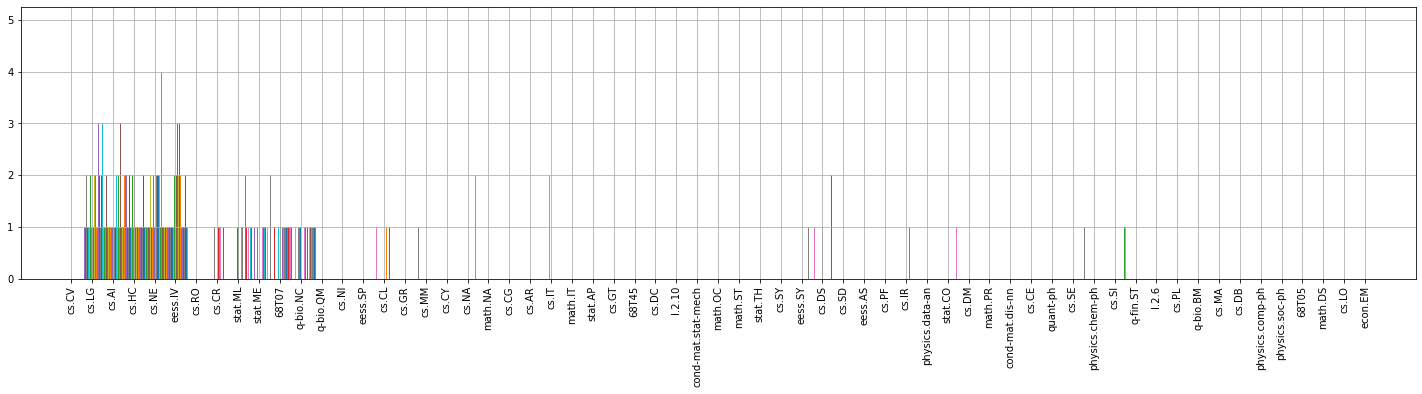

In [ ]:
## distribution
plt.figure(figsize=(25,5))
plt.xticks(rotation=90)
df_clean.terms.hist();

There is imbalance in the target class. This imbalance will affect the accuracy of the multilabel classifier.

## B) Features Inspection [4 points]

Now let's dig into the 'feature' columns (`titles` and `summaries`). Your analysis could include (but is not restricted to):
- What are the most common words in each feature column?
- What is the average word count?
- Do word count distributions differ for instances with different 'terms' (labels)?

In [ ]:
# [YOUR CODE HERE]
## common words in each column


## C) Train Test Split [1 point]

Perform the usual train-test-validation split. The validation set will be used during training (potentially for early-stopping criteria). The test set will be used to evaluate our models once we are happy with their performance.

In [ ]:
# [YOUR CODE HERE]

# Part 2: Data Preprocessing [6 points]
***


## A) Multi-Label Encoding [1 point]

Alright, now that we have a good handle on the data, lets start to perform some preprocessing to prepare the data for our machine learning models.

First you need to multi-hot encode the labels **(we can have more than 1 label per observation, so we use multi-hot as opposed to one-hot label encoding)**. We have already taken care of this for the training data using sklearn's `MultiLabelBinarizer`. All you need to do is **apply the same processing steps to the test and validation sets.** You are encouraged to look at the `MultiLabelBinarizer` docs if you don't understand the outputs of this module.

> **NOTE:** The code below assumes you have you train set stored in the variable `train_df`; make adjustments to this variable as needed.

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

y_train = mlb.fit_transform(train_df.terms.apply(set))

# Should produce a matrix of shape (m, C), where m is # of observations, C is number of classes
print(y_train.shape)
y_train[0:2]

In [ ]:
# [YOUR CODE HERE]
# y_val = ...
# y_test = ...

## B) Text Preprocessing [5 points]

Next we need to preprocess our text data. There are two main components to any basic text preprocessing pipeline:

1. Perform text cleaning / tokenization. The whole process typically includes the following steps:
    - Lowercase
    - Remove punctuation, stematize, lematize (all optional)
    - Tokenization
    - Remove stop words
2. Text vectorization. For this you could use a basic count vectorizer or a more sophisticated approach (like TF-IDF).

Lucky for us, both of these steps can be taken care of with the use of sklearn's text preprocessing tools, namely `CountVectorizer` and `TfidfVectorizer`. If you look at the docs, you will see that these classes include arguments for the various text preprocessing steps (e.g. `strip_accents`, `lowercase`, `tokenizer`) as well as the vectorization steps (e.g `n_gram_range`, `max_features`). We have provided an example of how this works below. 

> **NOTE:**  Be sure to perform vectorization for the train, validation, and test sets (but be careful when calling `fit` vs `fit_transform`).

In [ ]:
# Sample vectorization code
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

STOPWORDS = {'should', 'were', 'only', 'i', 'down', 'mightn', 'that', 'and', 'over', 'under', "wouldn't", 'now', 'hasn', "you'll", 'or', 'ours', 'my', 'does', 'd', 'no', 'because', 'very', 'but', 'such', "hadn't", "haven't", 'ain', 'yourself', 'weren', 'after', "hasn't", 'we', 'not', 'hers', 'how', 'don', 'doesn', 'me', "you'd", 'when', "shouldn't", 'having', 'he', 'through', 'can', 'themselves', 'whom', 'on', 'them', 'again', 'at', 'if', 'has', 'the', 'wouldn', 'isn', 'do', 'these', "don't", "aren't", 'too', 'just', 'their', 'most', "should've", 'was', 'did', 'yours', 'once', 's', 'from', 'off', 'myself', "that'll", 'will', 'doing', 'theirs', "you're", 'our', 'have', 'mustn', 'himself', 'of', 'her', 'until', 'more', 'while', 'him', 'there', 'between', 'below', 'your', 'a', 'yourselves', 'herself', 'into', 'who', "weren't", 'she', 'they', 'it', 'is', 'all', 'ma', 'both', 'needn', 'as', 'up', 'wasn', 'further', "didn't", 'here', 'so', 'by', 'above', 'few', 'had', "isn't", 'won', 'an', 'be', 'other', "couldn't", 'itself', 'nor', 'hadn', 'any', "needn't", "shan't", 'own', 'where', 'then', 'shouldn', 'this', 't', "it's", 'shan', 'each', "you've", 'in', 'are', "mustn't", 'which', 'during', 'for', 'same', 'why', 'haven', 'didn', "won't", 'what', 'y', 'before', 'being', 'ourselves', 've', 'll', 'out', "wasn't", 're', 'some', 'o', 'his', 'those', 'm', 'been', 'to', 'with', 'am', 'against', "mightn't", 'than', 'aren', 'couldn', "she's", 'its', 'you', "doesn't", 'about'}

examples = [
    "Hello world! My name is Samantha and I like machine learning",
    "I like turtles",
    "One day, the machines will rise to enslave humanity"
]
            
cv = CountVectorizer(lowercase=True, stop_words=STOPWORDS, max_features=10)
examples_vectorized = cv.fit_transform(examples) # outputs spare matrix
print(cv.vocabulary_)

examples_vectorized.A # use .A to convert sparse to dense array for inspection

In [ ]:
### [YOUR CODE HERE]

# Part 3: Model Building [16 points]
***

Alright, we have our dataset and our labels, now its time to train some models! We are going to build 3 neural network models:
- Model A): Use vectorized titles data
- Model B): Use vectorized abstract data
- Model C): Use both titles AND abstract data

When building each model, there are a couple things you need to keep in mind:

- You may use the keras sequential or functional API, though the sequential API is probably simplest for the first two models.
- The model should have **at least 1 hidden layer**, with a non-linear activation function of your choice.
- Your hidden layer(s) can have any number of neurons (though typically this ranges from 32 to 512)
- This is a multi-class problem, so we *could* use the `softmax` actiavtion function in our final layer. However because this is a multi-class AND multi-label problem, **we are instead going to use the `sigmoid` activation function with 63 output neurons (one for each of the target classes).** This will make evaluation easy; we can simply use the standard "accuracy", "recall" and "precision" metrics (think of this like training 63 binary classification models with a single neural network!)
- You will want to feed in the validation data to the `.fit` method to ensure your accuracy/recall is increasing as your loss decreases.
- Train for as many epochs as you see fit (or try using an early stopping callback to stop training once validation precision or recall stops increasing).

> 💡 Tip: If model training is taking too long and preventing you from completing the assignment in time, then you can do one of two things. Either limit the number of epochs and do your best to optimize within that constraint (preferred). Or reduce the dataset size by taking a random subset of the data (more risky because your network might not have enough data to learn anything useful). Try your best without these restrictions, but know that you have this option as a backup plan, if you are truly running out of time.

Note that **recall** in this example is particularily useful, as most observations only have 1-3 labels (meaning that on average the model should *hopefully* predict low probability scores for ~60 classes). We have provided an example of how recall and precision work below, but all you will have to do is insert them into the `model.compile` method as follows:

```
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy", tf.keras.metrics.Recall(), tf.keras.metrics.Precision()],
)

```

In [ ]:
# Recall/Precision example
R = tf.keras.metrics.Recall()
P = tf.keras.metrics.Precision()

# 3 observations
y_true = [
    [1,0,0,1,1], # 3 labels
    [0,1,0,0,0], # 1 labels
    [0,1,1,0,0], # 2 labels
]

# Sigmoid ouputs
y_pred = [
    [0.9, 0.1, 0.2, 0.9, 0.4], # recall = 2/3, precision = 2/2 
    [0.9, 0.9, 0.1, 0.1, 0.9], # recall = 1/1, precision = 1/3 
    [0.1, 0.6, 0.1, 0.3, 0.9], # recall = 1/2, precision = 1/2
]

# 4 positives predicted correctly / 6 true positives = recall of 0.66
print(R(y_true, y_pred))

# 4 positives predicted correctly / 7 positives predicted = precision of 0.57
print(P(y_true, y_pred))

## A) Titles Model [5 points]

Lets start by building a model that **uses only titles data** as its input feature (ignore 'summaries' for now). 

Start with a model that only has 1 hidden dense layer (`tf.keras.layers.Dense`), and then try experimenting with additional layers/neurons/activation functions. 


In [ ]:
# [YOUR CODE HERE]

## B) Summaries Model [3 points]

Now lets try train the exact same model, but this time using only the summaries vectorized data. Do not use the 'titles' feature.

In [ ]:
# [YOUR CODE HERE]

## C) Titles and Summaries Model [6 points]

Now lets create a model that accepts both inputs! You will need to adjust your model to accept two inputs, and add a concatenation layer that fuses them together in a single tensor. Then send the concatenated input directly through the dense layers just as you did above. 

> **NOTE:** Remember to include both inputs when calling the `model.fit` method. Also note that that your inputs should be larger than the inputs for the models above. This may slow down training significantly (depending on your hardware), so you may want to try increasing the batch size to speed things up (a batch size of 2024 is probably as high as you want to go).

In [ ]:
# [YOUR CODE HERE]

## D) Evaluate Models [2 points]

Evaluate all 3 models on the test set. Which one performed best? Did the third model yield a large enough accuracy boost (if at all) to warrant the increased training time?

In [ ]:
# [YOUR CODE HERE]